# Twitter Sentiment Analysis - Baseline Models

This notebook implements and evaluates baseline machine learning models for Twitter sentiment analysis.

## Models to Implement
1. **Logistic Regression** - Linear baseline with TF-IDF features
2. **Random Forest** - Non-linear ensemble method with TF-IDF features

## Objectives
1. Load preprocessed data from previous notebook
2. Train and evaluate baseline models
3. Perform hyperparameter tuning
4. Compare model performance
5. Generate comprehensive evaluation metrics
6. Save trained models for future use

## Evaluation Metrics
- Accuracy, Precision, Recall, F1-score
- ROC-AUC score
- Confusion Matrix
- Cross-validation results
- Feature importance analysis


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Ensure output directories exist
os.makedirs('../models/saved_models', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

# Set up
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")


Libraries imported successfully!
Current working directory: c:\Users\acer\Desktop\ml_proj\notebooks


In [2]:
# Load preprocessed data
print("Loading preprocessed data...")

# Load TF-IDF features
X_tfidf_train = np.load('../data/processed/X_tfidf_train.npy')
X_tfidf_test = np.load('../data/processed/X_tfidf_test.npy')

# Load labels
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

# Load TF-IDF vectorizer
with open('../models/saved_models/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

print(f"TF-IDF Train shape: {X_tfidf_train.shape}")
print(f"TF-IDF Test shape: {X_tfidf_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# Check class distribution
print(f"\\nTrain class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Feature scaling for Logistic Regression
print("\\nScaling features for Logistic Regression...")
scaler = StandardScaler()
X_tfidf_train_scaled = scaler.fit_transform(X_tfidf_train)
X_tfidf_test_scaled = scaler.transform(X_tfidf_test)

print("Data loading and preprocessing completed!")


Loading preprocessed data...
TF-IDF Train shape: (15992, 5000)
TF-IDF Test shape: (3998, 5000)
Train labels shape: (15992,)
Test labels shape: (3998,)
\nTrain class distribution: [7996 7996]
Test class distribution: [1999 1999]
\nScaling features for Logistic Regression...
Data loading and preprocessing completed!


In [3]:
# Model evaluation functions
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Comprehensive model evaluation"""
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    
    # Store results
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    return results, model

def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{model_name} - Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_roc_curve(y_true, y_pred_proba, model_name, ax):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves Comparison')
    ax.legend()

print("Evaluation functions defined successfully!")


Evaluation functions defined successfully!


In [4]:
# Model 1: Logistic Regression
print("=== LOGISTIC REGRESSION MODEL ===")

# Initialize Logistic Regression
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)

# Evaluate the model
print("Training and evaluating Logistic Regression...")
lr_results, lr_trained = evaluate_model(
    lr_model, X_tfidf_train_scaled, X_tfidf_test_scaled, 
    y_train, y_test, "Logistic Regression"
)

# Print results
print(f"\nLogistic Regression Results:")
print(f"Accuracy: {lr_results['accuracy']:.4f}")
print(f"Precision: {lr_results['precision']:.4f}")
print(f"Recall: {lr_results['recall']:.4f}")
print(f"F1-Score: {lr_results['f1_score']:.4f}")
print(f"ROC-AUC: {lr_results['roc_auc']:.4f}")
print(f"CV F1-Score: {lr_results['cv_mean']:.4f} (+/- {lr_results['cv_std']*2:.4f})")

# Hyperparameter tuning for Logistic Regression (reduced grid for faster training)
print("\nPerforming hyperparameter tuning...")
lr_param_grid = {
    'C': [0.1, 1, 10],  # Reduced parameter options
    'penalty': ['l2'],   # Only L2 for faster convergence
    'solver': ['liblinear']  # Faster solver
}

lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    lr_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

lr_grid_search.fit(X_tfidf_train_scaled, y_train)

print(f"Best parameters: {lr_grid_search.best_params_}")
print(f"Best CV score: {lr_grid_search.best_score_:.4f}")

# Train with best parameters
lr_best = lr_grid_search.best_estimator_
lr_best_results, lr_best_trained = evaluate_model(
    lr_best, X_tfidf_train_scaled, X_tfidf_test_scaled,
    y_train, y_test, "Logistic Regression (Tuned)"
)

print(f"\nTuned Logistic Regression Results:")
print(f"F1-Score: {lr_best_results['f1_score']:.4f}")
print(f"ROC-AUC: {lr_best_results['roc_auc']:.4f}")

# Save the best model (ensure directory exists)
os.makedirs('../models/saved_models', exist_ok=True)
joblib.dump(lr_best_trained, '../models/saved_models/logistic_regression_model.pkl')
joblib.dump(scaler, '../models/saved_models/scaler.pkl')
print("\nLogistic Regression model saved!")


=== LOGISTIC REGRESSION MODEL ===
Training and evaluating Logistic Regression...

Logistic Regression Results:
Accuracy: 0.6788
Precision: 0.6733
Recall: 0.6948
F1-Score: 0.6839
ROC-AUC: 0.7143
CV F1-Score: 0.6591 (+/- 0.0168)

Performing hyperparameter tuning...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.6632

Tuned Logistic Regression Results:
F1-Score: 0.6873
ROC-AUC: 0.7272

Logistic Regression model saved!


In [5]:
# Model 2: Random Forest
print("=== RANDOM FOREST MODEL ===")

# Initialize Random Forest
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    class_weight='balanced',
    n_jobs=-1
)

# Evaluate the model
print("Training and evaluating Random Forest...")
rf_results, rf_trained = evaluate_model(
    rf_model, X_tfidf_train, X_tfidf_test, 
    y_train, y_test, "Random Forest"
)

# Print results
print(f"\nRandom Forest Results:")
print(f"Accuracy: {rf_results['accuracy']:.4f}")
print(f"Precision: {rf_results['precision']:.4f}")
print(f"Recall: {rf_results['recall']:.4f}")
print(f"F1-Score: {rf_results['f1_score']:.4f}")
print(f"ROC-AUC: {rf_results['roc_auc']:.4f}")
print(f"CV F1-Score: {rf_results['cv_mean']:.4f} (+/- {rf_results['cv_std']*2:.4f})")

# Hyperparameter tuning for Random Forest (reduced grid for faster training)
print("\nPerforming hyperparameter tuning...")
rf_param_grid = {
    'n_estimators': [50, 100],  # Reduced options
    'max_depth': [10, 20],      # Reduced options
    'min_samples_split': [2, 5], # Reduced options
    'min_samples_leaf': [1, 2]   # Reduced options
}

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_tfidf_train, y_train)

print(f"Best parameters: {rf_grid_search.best_params_}")
print(f"Best CV score: {rf_grid_search.best_score_:.4f}")

# Train with best parameters
rf_best = rf_grid_search.best_estimator_
rf_best_results, rf_best_trained = evaluate_model(
    rf_best, X_tfidf_train, X_tfidf_test,
    y_train, y_test, "Random Forest (Tuned)"
)

print(f"\nTuned Random Forest Results:")
print(f"F1-Score: {rf_best_results['f1_score']:.4f}")
print(f"ROC-AUC: {rf_best_results['roc_auc']:.4f}")

# Save the best model (ensure directory exists)
os.makedirs('../models/saved_models', exist_ok=True)
joblib.dump(rf_best_trained, '../models/saved_models/random_forest_model.pkl')
print("\nRandom Forest model saved!")


=== RANDOM FOREST MODEL ===
Training and evaluating Random Forest...

Random Forest Results:
Accuracy: 0.7156
Precision: 0.6966
Recall: 0.7639
F1-Score: 0.7287
ROC-AUC: 0.7876
CV F1-Score: 0.7310 (+/- 0.0128)

Performing hyperparameter tuning...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score: 0.7337

Tuned Random Forest Results:
F1-Score: 0.7399
ROC-AUC: 0.7793

Random Forest model saved!


=== MODEL COMPARISON ===
\nModel Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0  Logistic Regression    0.6821     0.6762  0.6988    0.6873   0.7272   
1        Random Forest    0.7031     0.6583  0.8444    0.7399   0.7793   

   CV F1-Score  
0       0.6684  
1       0.7334  


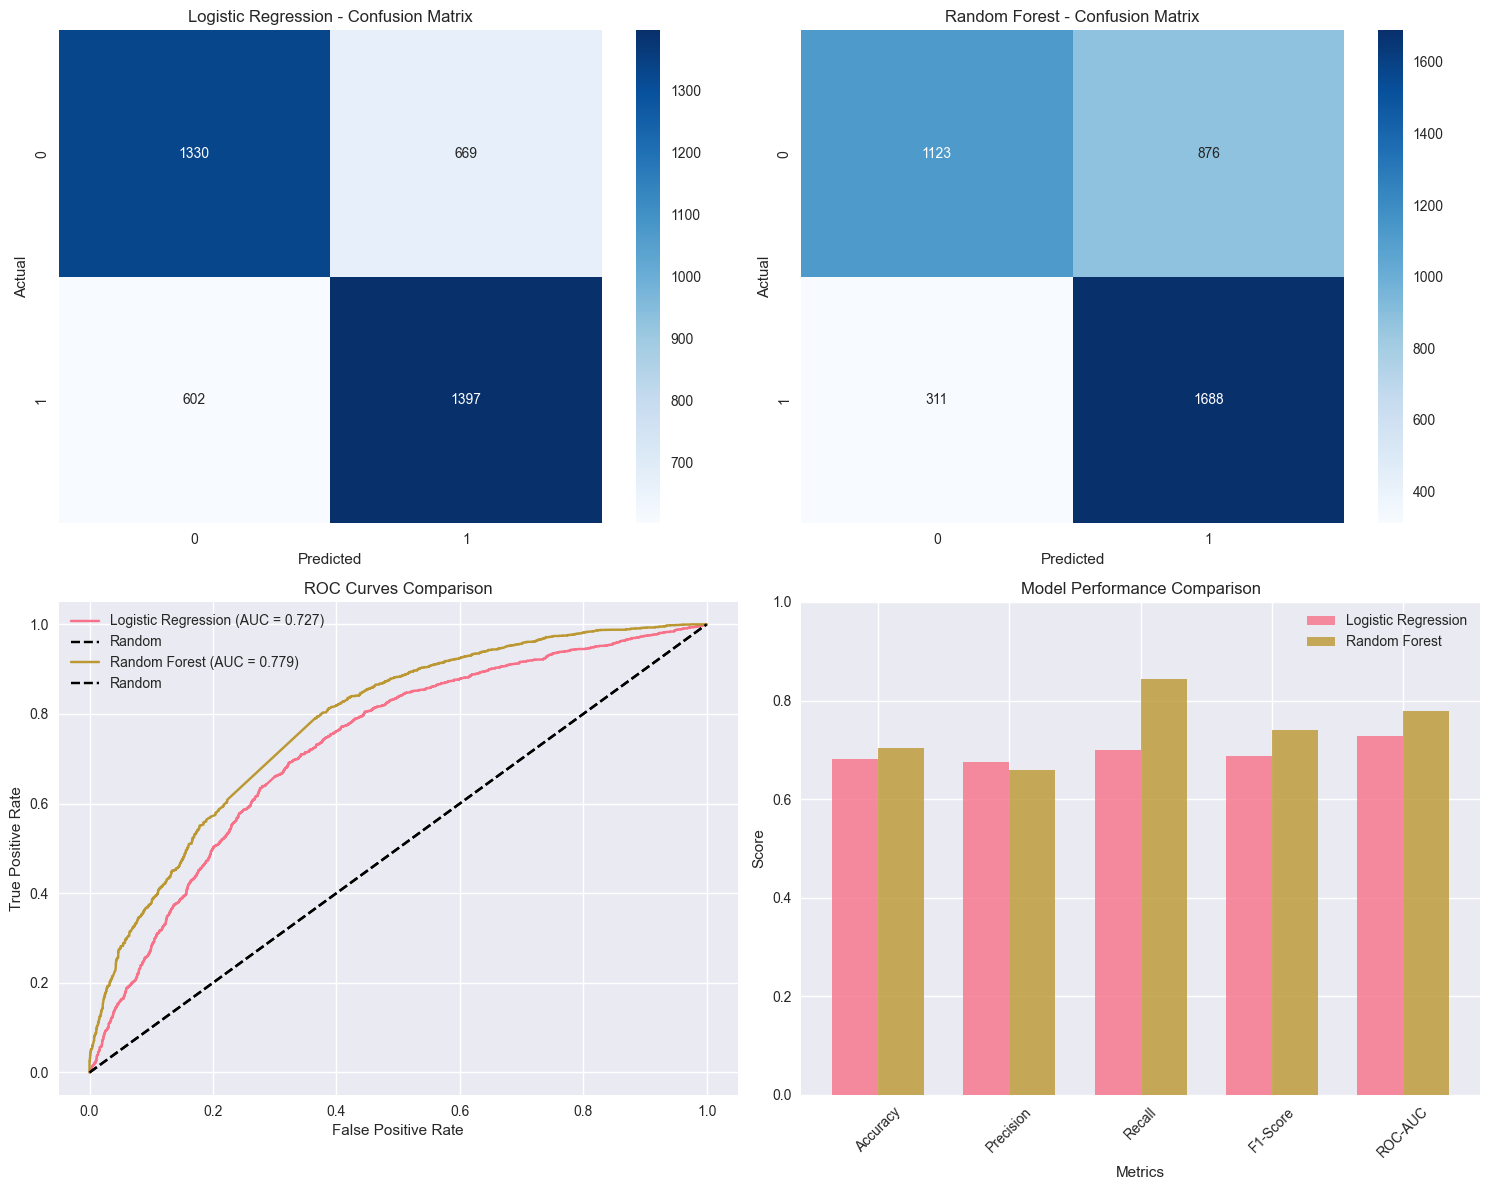

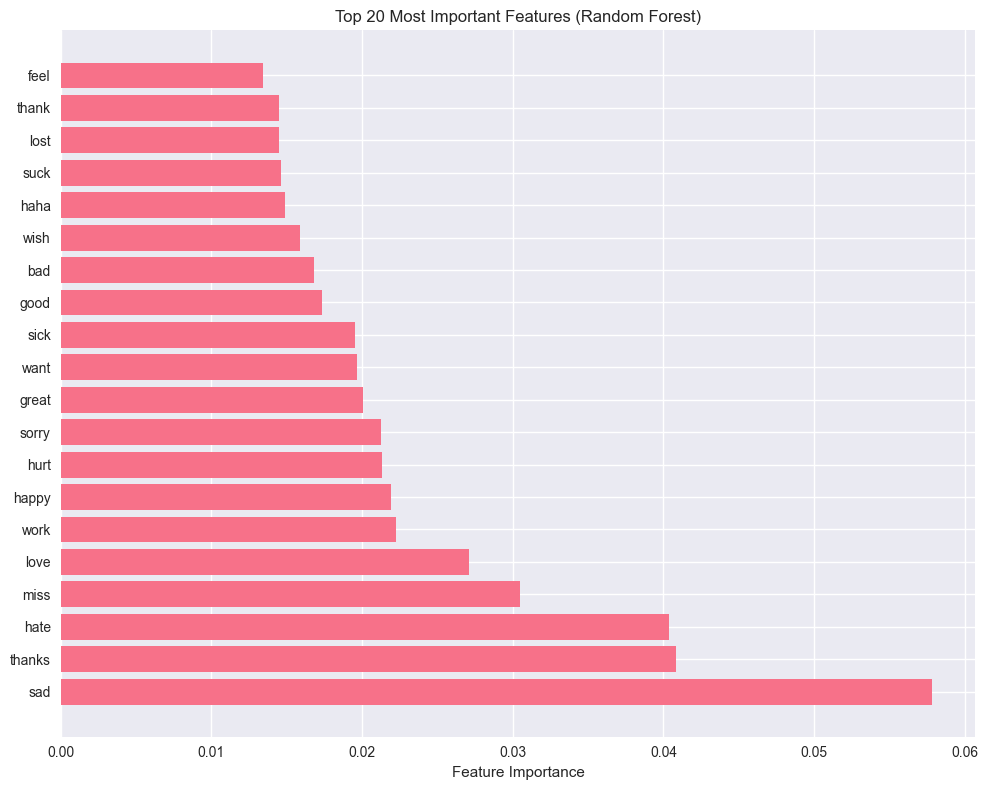

\n✅ Baseline models training and evaluation completed!
\nNext steps:
1. Proceed to deep learning models (LSTM, BERT)
2. Conduct fairness analysis
3. Test adversarial robustness


In [6]:
# Model comparison and visualization
print("=== MODEL COMPARISON ===")

# Create comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_best_results['accuracy'], rf_best_results['accuracy']],
    'Precision': [lr_best_results['precision'], rf_best_results['precision']],
    'Recall': [lr_best_results['recall'], rf_best_results['recall']],
    'F1-Score': [lr_best_results['f1_score'], rf_best_results['f1_score']],
    'ROC-AUC': [lr_best_results['roc_auc'], rf_best_results['roc_auc']],
    'CV F1-Score': [lr_best_results['cv_mean'], rf_best_results['cv_mean']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\\nModel Performance Comparison:")
print(comparison_df.round(4))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion matrices
plot_confusion_matrix(y_test, lr_best_results['y_pred'], 'Logistic Regression', axes[0, 0])
plot_confusion_matrix(y_test, rf_best_results['y_pred'], 'Random Forest', axes[0, 1])

# ROC curves
plot_roc_curve(y_test, lr_best_results['y_pred_proba'], 'Logistic Regression', axes[1, 0])
plot_roc_curve(y_test, rf_best_results['y_pred_proba'], 'Random Forest', axes[1, 0])

# Performance metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
lr_scores = [lr_best_results[metric.lower().replace('-', '_')] for metric in metrics]
rf_scores = [rf_best_results[metric.lower().replace('-', '_')] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x - width/2, lr_scores, width, label='Logistic Regression', alpha=0.8)
axes[1, 1].bar(x + width/2, rf_scores, width, label='Random Forest', alpha=0.8)
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics, rotation=45)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('../reports/figures/baseline_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance for Random Forest
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importance = rf_best_trained.feature_importances_

# Get top 20 most important features
top_indices = np.argsort(feature_importance)[-20:]
top_features = feature_names[top_indices]
top_importance = feature_importance[top_indices]

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\\n✅ Baseline models training and evaluation completed!")
print("\\nNext steps:")
print("1. Proceed to deep learning models (LSTM, BERT)")
print("2. Conduct fairness analysis")
print("3. Test adversarial robustness")
